In [1]:
from _import_scripts import scripts
from scripts.notebook_utils import *

display_markdown(
    """
# Editing Variables

This tutorial builds off the previous basic CiM array tutorial. If you haven't
already, you should go through that tutorial first. In this tutorial, we will
explore the variables files and use them to define different parameters of the
CiM macro.

## Introduction and Overview

We use two variables files for each CiMLoop macro:

- `variables_iso.yaml` contains variables that should be kept the same when
  comparing different macros. For all macros, we keep the structure of this file
  the same such that we can swap `variables_iso.yaml` files between different
  macros. Example variables that this file contains include the technology node,
  the system voltage, and the workload batch size.

- `variables_free.yaml` contains variables that can be freely changed for each
  macro. Example variables that this file contains include the resolution of the
  ADC and DAC, the encoding scheme used for each operand, the clock period, and
  any other variables that are specific to the macro being used.
  
In all variables, we can use formulas to calculate the value of a variable based
on previously-defined variables.

*Note: The variables files are fully user-defined; you may add or remove
variables or create/use entirely different variables files. Many variables
connect to component models (described in later tutorials), and components can
be freely added or modified alongside any variables that they connect to.*

We will be setting the variables for the following macro. In the diagram, we
show a 3x3 weight matrix and a 3x3 array for illustrative purposes, but in
simulation we'll be using a 32x32 array.

![Analog CiM Macro](images/how_cim_works.svg)
"""
)


# Editing Variables

This tutorial builds off the previous basic CiM array tutorial. If you haven't
already, you should go through that tutorial first. In this tutorial, we will
explore the variables files and use them to define different parameters of the
CiM macro.

## Introduction and Overview

We use two variables files for each CiMLoop macro:

- `variables_iso.yaml` contains variables that should be kept the same when
  comparing different macros. For all macros, we keep the structure of this file
  the same such that we can swap `variables_iso.yaml` files between different
  macros. Example variables that this file contains include the technology node,
  the system voltage, and the workload batch size.

- `variables_free.yaml` contains variables that can be freely changed for each
  macro. Example variables that this file contains include the resolution of the
  ADC and DAC, the encoding scheme used for each operand, the clock period, and
  any other variables that are specific to the macro being used.
  
In all variables, we can use formulas to calculate the value of a variable based
on previously-defined variables.

*Note: The variables files are fully user-defined; you may add or remove
variables or create/use entirely different variables files. Many variables
connect to component models (described in later tutorials), and components can
be freely added or modified alongside any variables that they connect to.*

We will be setting the variables for the following macro. In the diagram, we
show a 3x3 weight matrix and a 3x3 array for illustrative purposes, but in
simulation we'll be using a 32x32 array.

![Analog CiM Macro](images/how_cim_works.svg)


In [2]:
display_markdown(
    """
### The `variables_iso.yaml` File 

The `variables_iso.yaml` file for the basic analog CiM macro is shown below.

It contains several important pieces.

- Workload information: The number of bits for each workload operand, the batch
  size, and histograms for each operand. The histograms represent the
  distribution of values that each operand can take on, and are used to
  calculate the energy of various components. Histograms listed here are just
  defaults, and will be overridden if more-specific histograms are provided in a
  the definition of a given DNN layer.

- Microarchitecture: The number of supported bits for each operand. These are
  usually used to set the sizes of buffers and other components.

- Circuits: The technology node, supply voltage, and memory cell file are set
  here. We also define scaling factors for the energy and latency relative to
  the supply voltage.

- Calibration parameters: These are used to calibrate the energy and area of
  various components to account for circuit-level differences and post-layout
  effects.
"""
)

MACRO_PATH = "../models/arch/1_macro/basic_analog/"
display_yaml_file(os.path.join(MACRO_PATH, "variables_iso.yaml"))


### The `variables_iso.yaml` File 

The `variables_iso.yaml` file for the basic analog CiM macro is shown below.

It contains several important pieces.

- Workload information: The number of bits for each workload operand, the batch
  size, and histograms for each operand. The histograms represent the
  distribution of values that each operand can take on, and are used to
  calculate the energy of various components. Histograms listed here are just
  defaults, and will be overridden if more-specific histograms are provided in a
  the definition of a given DNN layer.

- Microarchitecture: The number of supported bits for each operand. These are
  usually used to set the sizes of buffers and other components.

- Circuits: The technology node, supply voltage, and memory cell file are set
  here. We also define scaling factors for the energy and latency relative to
  the supply voltage.

- Calibration parameters: These are used to calibrate the energy and area of
  various components to account for circuit-level differences and post-layout
  effects.


```yaml
# These variables pertain to the workload, microarch, and circuits. They should
# be matched between architectures when comparing for a fair comparison.
# Furthermore, this file should follow the same format for all architectures
# such that we can mix and match architectures with different iso files.
variables:
  version: 0.4
  # ===========================================================================
  # Workload, microarch, circuits. Things that should be matched
  # between architectures when comparing.
  # ===========================================================================
  ## Workload -----------------------------------------------------------------
  WEIGHT_BITS: 8
  INPUT_BITS:  8
  OUTPUT_BITS: 8
  BATCH_SIZE:  1

  # Set by CiM processor if these values are available in the workload.
  # Otherwise, use the defaults here.
  INPUTS_HIST: [0, 0, 0, 3, 2, 1, 0]
  WEIGHTS_HIST: ([1] * 15)
  OUTPUTS_HIST: INPUTS_HIST

  ## Microarch ----------------------------------------------------------------
  SUPPORTED_INPUT_BITS:  8       # Maximum input bits supported by the arch.
  SUPPORTED_WEIGHT_BITS: 8       # Maximum weight bits supported by the arch.
  SUPPORTED_OUTPUT_BITS: 8       # Maximum output bits supported by the arch.

  # Circuits ------------------------------------------------------------------
  VOLTAGE: 1
  TECHNOLOGY: 65 # nm
  CELL_CONFIG: "{{find_path(cell_override|default('rram_example.cell.yaml'))}}"
  VOLTAGE_ENERGY_SCALE: VOLTAGE ** 2 # Quadratic scaling
  VOLTAGE_LATENCY_SCALE: 1 / VOLTAGE # Linear scaling
  
  # Calibration ---------------------------------------------------------------
  ADC_ENERGY_SCALE: VOLTAGE_ENERGY_SCALE
  ADC_AREA_SCALE: 1
  ROW_COL_DRIVERS_AREA_SCALE: 1
```

In [3]:
display_markdown(
    """
### The `variables_free.yaml` File 


The `variables_free.yaml` file is evaluated after the `variables_iso.yaml` file,
so any variables defined in the `variables_iso.yaml` file can be used in the
`variables_free.yaml` file.

The `variables_free.yaml` file for the basic analog CiM macro is shown below. It
contains several important pieces:

- CiM array parameters: The number of rows and columns in the array and the
  number of parallel inputs, outputs, and weights that are processed in each
  cycle. These are set automatically by the CiM processor upon processing a
  specification, and can be used in formulas to calculate other variables.
  
- Operand encoding: The number of bits used to encode each operand and encoding
  functions. Note that, for each operand here, we define one encoding and one
  number of bits. In real systems, the encoding and number of bits may change as
  operands move through the system, so we may define additional encodings and/or
  numbers of bits in the variables file.
  
- Architecture & CiM Array Structure: The number of memory cells of width and
  depth for the CiM unit is defined here. Cells along width store different bits
  of the same operand, computing a single MAC operation together. Cells along
  depth store different operands and are activated in different cycles. Finally,
  the bits per cell defines how many bits can be stored in a single memory cell.
  
- Data converters: The ADC and DAC resolution are defined here, as well as the
  number of ADCs in a bank.
  
- Other hardware parameters: The clock period, or `GLOBAL_CYCLE_SECONDS`, is
  defined here, as well as the read pulse width, or the amount of time that a
  row is asserted during a read of the CiM array.

- Anything else: Any other parameters that are specific to the macro being used
  can be defined here.
"""
)
display_yaml_file(os.path.join(MACRO_PATH, "variables_free.yaml"))


### The `variables_free.yaml` File 


The `variables_free.yaml` file is evaluated after the `variables_iso.yaml` file,
so any variables defined in the `variables_iso.yaml` file can be used in the
`variables_free.yaml` file.

The `variables_free.yaml` file for the basic analog CiM macro is shown below. It
contains several important pieces:

- CiM array parameters: The number of rows and columns in the array and the
  number of parallel inputs, outputs, and weights that are processed in each
  cycle. These are set automatically by the CiM processor upon processing a
  specification, and can be used in formulas to calculate other variables.
  
- Operand encoding: The number of bits used to encode each operand and encoding
  functions. Note that, for each operand here, we define one encoding and one
  number of bits. In real systems, the encoding and number of bits may change as
  operands move through the system, so we may define additional encodings and/or
  numbers of bits in the variables file.
  
- Architecture & CiM Array Structure: The number of memory cells of width and
  depth for the CiM unit is defined here. Cells along width store different bits
  of the same operand, computing a single MAC operation together. Cells along
  depth store different operands and are activated in different cycles. Finally,
  the bits per cell defines how many bits can be stored in a single memory cell.
  
- Data converters: The ADC and DAC resolution are defined here, as well as the
  number of ADCs in a bank.
  
- Other hardware parameters: The clock period, or `GLOBAL_CYCLE_SECONDS`, is
  defined here, as well as the read pulse width, or the amount of time that a
  row is asserted during a read of the CiM array.

- Anything else: Any other parameters that are specific to the macro being used
  can be defined here.


```yaml
# These variables pertain to various design choices. They do not need to be
# matched while comparing architectures.
variables:
  version: 0.4
  # ===========================================================================
  # Set by CiM Processor
  # ===========================================================================
  ARRAY_WORDLINES:        Should have been set by ArrayProcessor.
  ARRAY_BITLINES:         Should have been set by ArrayProcessor.
  ARRAY_PARALLEL_INPUTS:  Should have been set by ArrayProcessor.
  ARRAY_PARALLEL_OUTPUTS: Should have been set by ArrayProcessor.
  ARRAY_PARALLEL_WEIGHTS: Should have been set by ArrayProcessor.

  # ===========================================================================
  # Encoding-dependent parameters
  # ===========================================================================
  ENCODED_INPUT_BITS:  INPUT_BITS
  ENCODED_WEIGHT_BITS: WEIGHT_BITS
  ENCODED_OUTPUT_BITS: OUTPUT_BITS

  INPUT_ENCODING_FUNC: offset_encode_hist
  WEIGHT_ENCODING_FUNC: offset_encode_hist

  # ===========================================================================
  # Architecture & CiM Array Structure
  # ===========================================================================
  CIM_UNIT_WIDTH_CELLS:  1
  CIM_UNIT_DEPTH_CELLS:  1
  BITS_PER_CELL:         8

  # ===========================================================================
  # Data Converters
  # ===========================================================================
  ADC_RESOLUTION: 8
  VOLTAGE_DAC_RESOLUTION: 1
  TEMPORAL_DAC_RESOLUTION: 8
  DAC_RESOLUTION: max(VOLTAGE_DAC_RESOLUTION, TEMPORAL_DAC_RESOLUTION)
  N_ADC_PER_BANK: 8

  # ===========================================================================
  # Hardware
  # ===========================================================================
  BASE_LATENCY: 1e-7 # ns per cycle
  GLOBAL_CYCLE_SECONDS: BASE_LATENCY * VOLTAGE_LATENCY_SCALE
  READ_PULSE_WIDTH: 1e-9```

In [4]:
display_markdown(
    """
## Changing Variables

Variables can be updated by loading in a specification and updating the
`variables` attribute. Note that, when we update variables, we will be changing
values BEFORE the processing of formulas, so we can not set variables such as
`ARRAY_WORDLINES` and `ARRAY_BITLINES` directly. Instead, we may write that use
`ARRAY_WORDLINES` and `ARRAY_BITLINES`.The parsing process is described [in these
tutorials.](https://github.com/Accelergy-Project/timeloop-accelergy-exercises/)

Here, we make a basic function that loads a specification, updates the
variables, and runs the mapper for a maximum-utilization workload. We'll use
this and similar functions to perform some design space explorations.
"""
)
import matplotlib.pyplot as plt
import joblib


def run_set_variables(variables, array_rows=32, array_cols=32):
    # Load in the specification
    spec = get_spec("basic_analog")

    # Enable the MAX_UTILIZATION variable. This will generate a
    # workload that maximizes the utilization of the array.
    spec.variables["MAX_UTILIZATION"] = True

    # Set the array size
    spec.architecture.find("row").spatial.meshY = array_rows
    spec.architecture.find("column").spatial.meshX = array_cols

    # Set variables
    spec.variables.update(variables)

    return run_mapper(spec)


## Changing Variables

Variables can be updated by loading in a specification and updating the
`variables` attribute. Note that, when we update variables, we will be changing
values BEFORE the processing of formulas, so we can not set variables such as
`ARRAY_WORDLINES` and `ARRAY_BITLINES` directly. Instead, we may write that use
`ARRAY_WORDLINES` and `ARRAY_BITLINES`.The parsing process is described [in these
tutorials.](https://github.com/Accelergy-Project/timeloop-accelergy-exercises/)

Here, we make a basic function that loads a specification, updates the
variables, and runs the mapper for a maximum-utilization workload. We'll use
this and similar functions to perform some design space explorations.



### Example 1: Voltage Scaling
First, we'll look at the effect of voltage scaling on the energy efficiency and
throughput of the macro. We'll set the voltage to a range of values and plot the
energy efficiency and throughput of the macro at each voltage.



As defined in the scaling factors in the `variables_iso.yaml` file, the energy increases
quadratically with the voltage, leading to a decrease in energy efficiency. The throughput
increases linearly with the voltage as the cycle time decreases.


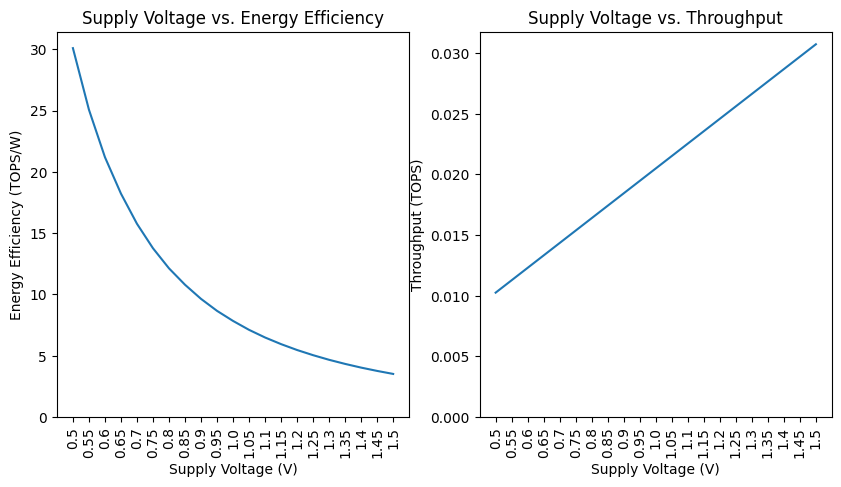

In [5]:
display_markdown(
    """
### Example 1: Voltage Scaling
First, we'll look at the effect of voltage scaling on the energy efficiency and
throughput of the macro. We'll set the voltage to a range of values and plot the
energy efficiency and throughput of the macro at each voltage.
"""
)

voltages = [x / 100 for x in range(50, 155, 5)]
results = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_set_variables)({"VOLTAGE": voltage}) for voltage in voltages
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot(
    {r.variables["VOLTAGE"]: r.tops_per_w for r in results},
    xlabel="Supply Voltage (V)",
    ylabel="Energy Efficiency (TOPS/W)",
    title="Supply Voltage vs. Energy Efficiency",
    ax=ax[0],
)
plot(
    {r.variables["VOLTAGE"]: r.tops for r in results},
    xlabel="Supply Voltage (V)",
    ylabel="Throughput (TOPS)",
    title="Supply Voltage vs. Throughput",
    ax=ax[1],
)

display_markdown(
    """
As defined in the scaling factors in the `variables_iso.yaml` file, the energy increases
quadratically with the voltage, leading to a decrease in energy efficiency. The throughput
increases linearly with the voltage as the cycle time decreases.
"""
)


### Example 2: Changing the Number of Input and Weight Bits 

Next, we'll vary the number of bits for inputs and weights, seeing how this
affects the energy efficiency and throughput of the macro. We'll vary input and
weight bits from 2 to 8 and plot the energy efficiency and throughput of the
macro for each configuration.

To make things more interesting, we'll limit the DAC resolution and the bits per
cell to be 1. To process higher-resolution inputs and weights while using
lower-resolution analog components, the mapper will *slice* the input and
weight, or divide them into smaller pieces with fewer bits, and process them
separately. Different input slices will be processed in different cycles, and
different weight slices will be mapped CiM units in the same row and adjacent
columns.



As shown in the plot, the energy efficiency and throughput both decrease as the
number of bits for inputs and weights increases. This is for two reasons. 

1. Each additional input bit requires an additional cycle to process. The additional
   cycle increases latency and reduces throughput. Furthermore, running the array
   for an additional cycle increases energy.
2. Each additional weight bit requires an additional CiM unit to store. This added
   hardware will reduce throughput and storage density, as the array can store
   and compute with fewer weights given the same number of CiM units. Furthermore,
   performing fewer computations per array activation will increase the energy per
   computation.


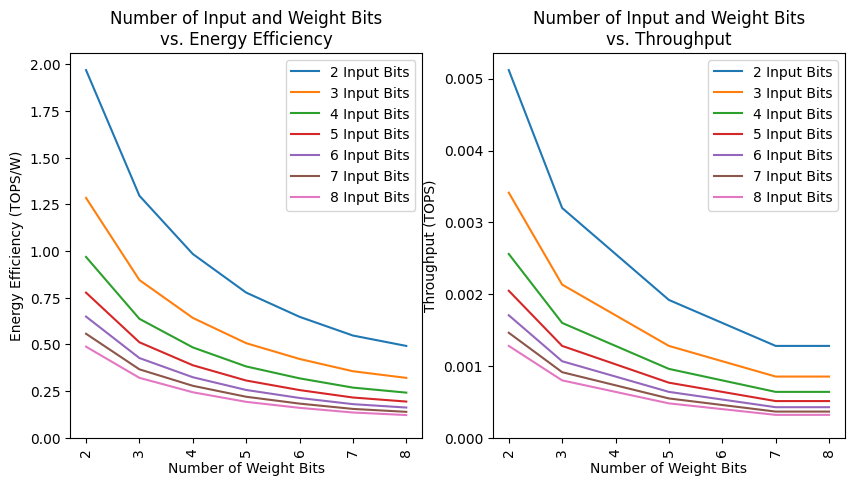

In [6]:
display_markdown(
    """
### Example 2: Changing the Number of Input and Weight Bits 

Next, we'll vary the number of bits for inputs and weights, seeing how this
affects the energy efficiency and throughput of the macro. We'll vary input and
weight bits from 2 to 8 and plot the energy efficiency and throughput of the
macro for each configuration.

To make things more interesting, we'll limit the DAC resolution and the bits per
cell to be 1. To process higher-resolution inputs and weights while using
lower-resolution analog components, the mapper will *slice* the input and
weight, or divide them into smaller pieces with fewer bits, and process them
separately. Different input slices will be processed in different cycles, and
different weight slices will be mapped CiM units in the same row and adjacent
columns.
"""
)

results = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_set_variables)(
        {
            "INPUT_BITS": input_bits,
            "WEIGHT_BITS": weight_bits,
            "DAC_RESOLUTION": 1,
            "BITS_PER_CELL": 1,
        }
    )
    for input_bits in range(2, 9)
    for weight_bits in range(2, 9)
)

# Plot the results
organized = {}
for r in results:
    organized.setdefault(r.variables["WEIGHT_BITS"], {})
    organized[r.variables["WEIGHT_BITS"]][f"{r.variables['INPUT_BITS']} Input Bits"] = r

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot(
    {k1: {k: v.tops_per_w for k, v in v1.items()} for k1, v1 in organized.items()},
    xlabel="Number of Weight Bits",
    ylabel="Energy Efficiency (TOPS/W)",
    title="Number of Input and Weight Bits\nvs. Energy Efficiency",
    ax=ax[0],
)
plot(
    {k1: {k: v.tops for k, v in v1.items()} for k1, v1 in organized.items()},
    xlabel="Number of Weight Bits",
    ylabel="Throughput (TOPS)",
    title="Number of Input and Weight Bits\nvs. Throughput",
    ax=ax[1],
)

display_markdown(
    """
As shown in the plot, the energy efficiency and throughput both decrease as the
number of bits for inputs and weights increases. This is for two reasons. 

1. Each additional input bit requires an additional cycle to process. The additional
   cycle increases latency and reduces throughput. Furthermore, running the array
   for an additional cycle increases energy.
2. Each additional weight bit requires an additional CiM unit to store. This added
   hardware will reduce throughput and storage density, as the array can store
   and compute with fewer weights given the same number of CiM units. Furthermore,
   performing fewer computations per array activation will increase the energy per
   computation.
"""
)


### Example 3: Changing the Device Type 

Finally, we'll look at the effect of changing the device type on the energy
efficiency and throughput of the macro. We'll compare two setups:

1. A macro that uses an RRAM device, storing four bits in each memory cell. Each
   CiM unit consists of one RRAM device.
2. A macro that uses an SRAM device, storing one bit in each memory cell. Each
   CiM unit consists of four SRAM devices to provide the same number of bits as
   the RRAM device.

To highlight the differences in devices, we'll use a larger array with 512 rows
and 512 columns, providing 128kB of storage in total.



First, we run a fast scenario, in which the macro is run with a 1e-7 second, or
100ns, cycle time. We'll end simulation ends as soon as the macro completes
computation. The energy breakdown for the fast scenario is shown below.


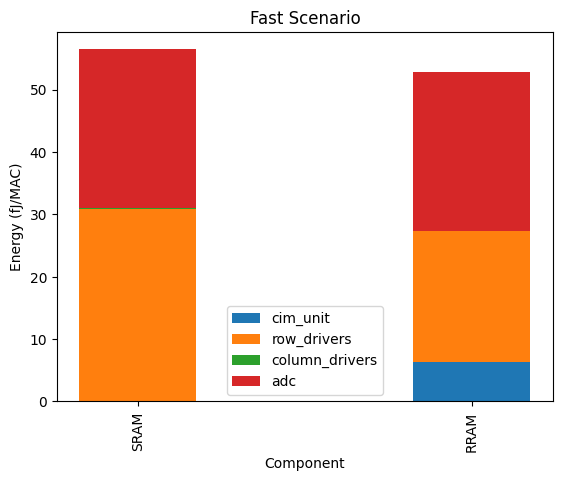


We can make several observations from this scenario:

1. For the CiM unit, RRAM energy is significantly higher than SRAM energy. This
   is because RRAM devices act as resistive elements, and current must be passed
   through them for read operations. This consumes power. In contrast, SRAM
   device reads do not require current to be passed through devices and thus
   consume less power.

2. For the column readout, energy is approximately equal.
   
3. For the input drivers, SRAM energy is significantly higher. This is because
   each SRAM device stores only one weight bit, relative to RRAM devices with
   store four bits. Therefore, more SRAM devices are required to store the same
   number of weights. This leads to a wider array with longer, higher-capacitance
   wordlines that require more power to drive.
   
Next, we run a slow scenario, in which the macro is run at a 1e-5 second, or
10us, cycle time. This simulates a scenario in which the macro must store
weights for a long time, and is activated only intermittently.


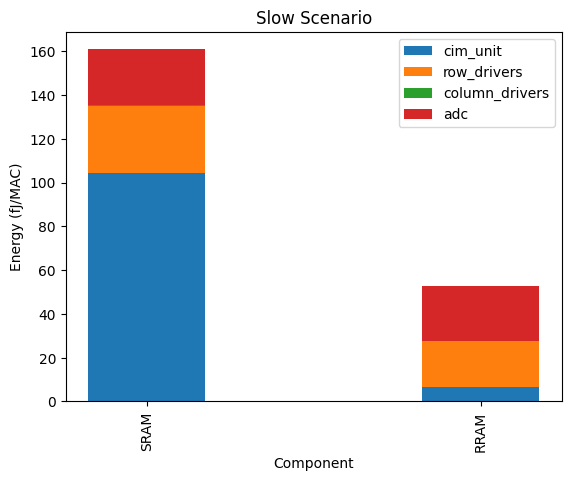


In this scenario, only one component of the energy breakdown changes. The SRAM
cim_unit energy is now much higher! This is because the SRAM devices require
power to maintain their state, and there is substantial leakage power in the
SRAM devices over the 100us cycle time. In contrast, the RRAM devices do not
require power to maintain their state, and thus do not leak power. The zero
leakage of RRAM is one reason why it is an attractive choice for low-power edge
and intermittently-activated systems.


In [7]:
display_markdown(
    """
### Example 3: Changing the Device Type 

Finally, we'll look at the effect of changing the device type on the energy
efficiency and throughput of the macro. We'll compare two setups:

1. A macro that uses an RRAM device, storing four bits in each memory cell. Each
   CiM unit consists of one RRAM device.
2. A macro that uses an SRAM device, storing one bit in each memory cell. Each
   CiM unit consists of four SRAM devices to provide the same number of bits as
   the RRAM device.

To highlight the differences in devices, we'll use a larger array with 512 rows
and 512 columns, providing 128kB of storage in total.
"""
)

# Strings in the YAML specification need to be enclosed in quotes
SRAM_PATH = f'"{os.path.abspath("../models/memory_cells/sram_example.cell.yaml")}"'
RRAM_PATH = f'"{os.path.abspath("../models/memory_cells/rram_example.cell.yaml")}"'


def run_test(global_cycle_seconds, title):
    results = joblib.Parallel(n_jobs=None)(
        joblib.delayed(run_set_variables)(
            {
                "CELL_CONFIG": path,
                "BITS_PER_CELL": 1 if path == SRAM_PATH else 4,
                "CIM_UNIT_WIDTH_CELLS": 4 if path == SRAM_PATH else 1,
                "GLOBAL_CYCLE_SECONDS": global_cycle_seconds,
                "IS_SRAM": path == SRAM_PATH,
            },
            512,
            512,
        )
        for path in [SRAM_PATH, RRAM_PATH]
    )
    organized = {}
    for r in results:
        r.clear_zero_energies()
        organized["SRAM" if r.variables["IS_SRAM"] else "RRAM"] = r.per_compute("per_component_energy")* 1e15
    bar_stacked(
        organized,
        title=title,
        xlabel="Component",
        ylabel="Energy (fJ/MAC)",
        missing_ok=True,
    )


display_markdown(
    """
First, we run a fast scenario, in which the macro is run with a 1e-7 second, or
100ns, cycle time. We'll end simulation ends as soon as the macro completes
computation. The energy breakdown for the fast scenario is shown below.
"""
)
run_test(1e-7, "Fast Scenario")
display_markdown(
    """
We can make several observations from this scenario:

1. For the CiM unit, RRAM energy is significantly higher than SRAM energy. This
   is because RRAM devices act as resistive elements, and current must be passed
   through them for read operations. This consumes power. In contrast, SRAM
   device reads do not require current to be passed through devices and thus
   consume less power.

2. For the column readout, energy is approximately equal.
   
3. For the input drivers, SRAM energy is significantly higher. This is because
   each SRAM device stores only one weight bit, relative to RRAM devices with
   store four bits. Therefore, more SRAM devices are required to store the same
   number of weights. This leads to a wider array with longer, higher-capacitance
   wordlines that require more power to drive.
   
Next, we run a slow scenario, in which the macro is run at a 1e-5 second, or
10us, cycle time. This simulates a scenario in which the macro must store
weights for a long time, and is activated only intermittently.
"""
)

run_test(1e-4, "Slow Scenario")

display_markdown(
    """
In this scenario, only one component of the energy breakdown changes. The SRAM
cim_unit energy is now much higher! This is because the SRAM devices require
power to maintain their state, and there is substantial leakage power in the
SRAM devices over the 100us cycle time. In contrast, the RRAM devices do not
require power to maintain their state, and thus do not leak power. The zero
leakage of RRAM is one reason why it is an attractive choice for low-power edge
and intermittently-activated systems.
"""
)